# **Data Science  Tools Project**


#### Consists of :
##### 1.`Data Extraction` (Web Scraping)
##### 2.`Store the data` in a file
##### 3.`Data Cleaning `
##### 4.`Data PreProcessing `
##### 5.`Regular Expressions`
##### 6`.Data Analysis`
##### 7.`Data Visualization`
##### 8.`Data Storage`
##### BOUNS: `Streamlit`(to represent the results in interactive WebPage)


## **Data Extraction(WebScraping)**

##### pip install beautifulsoup4  -> on the terminal

In [1]:
## we will make the scraping on: JUMIA

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import random
from tqdm import tqdm
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.preprocessing import MinMaxScaler
#!pip install pymongo


In [ ]:
# Configure session with headers to mimic browser behavior
session = requests.Session()

# Headers are used to simulate a browser request to avoid being blocked by the website
# The 'User-Agent' mimics a real browser to ensure the request is accepted as a legitimate one
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',  # Mimics Chrome browser
    'Accept-Language': 'en-US,en;q=0.9',  # Specifies the language preference for the page (English in this case)
    'Referer': 'https://www.jumia.com.eg/',  # Refers to the page that made the request, which is Jumia's homepage
    'DNT': '1'  # "Do Not Track" header is set to 1 to respect user privacy
}

# Update session with these headers
session.headers.update(headers)

# List of categories to scrape for comprehensive data collection
categories = [
    "smartphones",  # Smartphones category
    "laptops",  # Laptops category
    "televisions",  # Televisions category
    "home-audio",  # Home audio systems category
    "headphones",  # Headphones category
    "kitchen-appliances",  # Kitchen appliances category
    "men-watches",  # Men's watches category
    "women-watches",  # Women's watches category
    "fragrances",  # Fragrances category
    "mobile-accessories",  # Mobile accessories category
    "computing-accessories",  # Computing accessories category
    "gaming",  # Gaming category
    "cameras",  # Cameras category
    "printers-scanners"  # Printers and scanners category
]

# Number of pages to scrape per category (Jumia shows max 50 pages)
PAGES_PER_CATEGORY = 50

# Minimum delay between requests (in seconds) to avoid overloading the server
MIN_DELAY = 1
MAX_DELAY = 3

# Function to extract details from a single product card
def scrape_product_card(product):
    """Extract data from a single product card"""
    data = {}

    # Extract product name
    name_elem = product.find('h3', class_='name')
    data['name'] = name_elem.text.strip() if name_elem else None  # If name is found, strip extra spaces, else set as None

    # Extract current price
    price_elem = product.find('div', class_='prc')
    data['price'] = price_elem.text.strip() if price_elem else None  # If price is found, strip extra spaces, else set as None

    # Extract original price (if discounted)
    old_price_elem = product.find('div', class_='old')
    data['original_price'] = old_price_elem.text.strip() if old_price_elem else None  # If original price is found, strip extra spaces, else set as None

    # Extract discount percentage
    discount_elem = product.find('div', class_='bdg _dsct _sm')
    data['discount'] = discount_elem.text.strip() if discount_elem else None  # If discount is found, strip extra spaces, else set as None

    # Extract rating
    rating_elem = product.find('div', class_='stars _s')
    data['rating'] = rating_elem.text.strip() if rating_elem else None  # If rating is found, strip extra spaces, else set as None

    # Extract review count
    reviews_elem = product.find('div', class_='rev')
    data['review_count'] = reviews_elem.text.strip() if reviews_elem else None  # If review count is found, strip extra spaces, else set as None

    # Extract brand (assumed to be the first word in the product name)
    data['brand'] = data['name'].split()[0] if data['name'] else None  # If product name exists, split by space and take the first word

    # Extract seller information
    seller_elem = product.find('div', class_='bdg _mall _sm')
    data['seller'] = seller_elem.text.strip() if seller_elem else None  # If seller info is found, strip extra spaces, else set as None

    # Extract shipping information
    shipping_elem = product.find('div', class_='bdg _sv _sm')
    data['shipping'] = shipping_elem.text.strip() if shipping_elem else None  # If shipping info is found, strip extra spaces, else set as None

    # Extract product URL
    link_elem = product.find('a', href=True)
    data['url'] = 'https://www.jumia.com.eg' + link_elem['href'] if link_elem else None  # If product link exists, prepend the base URL

    return data

# Function to scrape a single page of Jumia products
def scrape_jumia_page(url):
    """Scrape a single page of Jumia products"""
    try:
        response = session.get(url)  # Make a GET request to the page
        response.raise_for_status()  # Raise an exception if there is any HTTP error
        soup = BeautifulSoup(response.text, 'html.parser')  # Parse the HTML response using BeautifulSoup

        # Find all product cards on the page
        products = soup.find_all('article', class_='prd _fb col c-prd')
        if not products:
            print(f"No products found at {url}")  # If no products found, log the page
            return None

        page_data = []  # List to store product data for the current page
        for product in products:
            product_data = scrape_product_card(product)  # Extract data from each product card
            page_data.append(product_data)  # Add the extracted product data to the list

        return page_data

    except requests.exceptions.RequestException as e:
        print(f"Error scraping {url}: {e}")  # If an error occurs during the request, log the error
        return None

# Function to scrape an entire category from Jumia
def scrape_jumia_category(category, max_pages):
    """Scrape an entire category from Jumia"""
    all_products = []  # List to store all products from the category

    # Loop through each page in the category
    for page in tqdm(range(1, max_pages + 1), desc=f"Scraping {category}"):
        url = f"https://www.jumia.com.eg/{category}/?page={page}"  # Construct the URL for the page
        page_data = scrape_jumia_page(url)  # Scrape the current page

        if page_data:
            all_products.extend(page_data)  # Add the page data to the category's product list

        # Random delay to avoid being blocked by the website
        time.sleep(random.uniform(MIN_DELAY, MAX_DELAY))

    return all_products

# Function to save scraped data to a JSON file
def save_data(data, filename):
    """Save scraped data to JSON file"""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)  # Save the data in a readable format

# Main function to initiate scraping process
def main():
    """Main scraping function"""
    all_data = {}  # Dictionary to store all scraped data for each category

    # Loop through each category and scrape data
    for category in categories:
        category_data = scrape_jumia_category(category, PAGES_PER_CATEGORY)  # Scrape the category
        all_data[category] = category_data  # Store the data for the category

        # Save data after scraping each category as a precaution
        save_data(all_data, 'jumia_data_partial.json')
        print(f"Saved {len(category_data)} products from {category}")

    # Final save after scraping all categories
    save_data(all_data, 'jumia_data_full.json')
    print(f"\nScraping complete. Total categories: {len(all_data)}")

    # Also save data as CSV for easier analysis later
    flat_data = []  # List to store all products in a flat structure
    for category, products in all_data.items():
        for product in products:
            product['category'] = category  # Add category information to each product
            flat_data.append(product)  # Add the product to the flat list

    df = pd.DataFrame(flat_data)  # Convert the list to a DataFrame for CSV export
    df.to_csv('jumia_data.csv', index=False, encoding='utf-8')  # Save the DataFrame as a CSV file
    print("Data also saved as CSV (jumia_data.csv)")

#if _name_ == "_main_":


main()


##**Pre-Processing:**

In [3]:
dff=pd.read_csv('jumia_data.csv')
dff

,name,price,original_price,discount,rating,review_count,brand,seller,shipping,url,category
0,Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G M...,"EGP 5,499.00","EGP 7,148.70",23%,4.1 out of 5,4.1 out of 5(16),Samsung,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,smartphones
1,"Samsung Galaxy A16 - 6.7"" 128GB/6GB Dual SIM 4...","EGP 7,850.00","EGP 9,420.00",17%,4 out of 5,4 out of 5(33),Samsung,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,smartphones
2,"Samsung Galaxy A16 - 6.7"" 256GB/8GB Dual SIM 4...","EGP 9,250.00","EGP 11,100.00",17%,4.4 out of 5,4.4 out of 5(18),Samsung,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,smartphones
3,Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G M...,"EGP 6,199.00","EGP 8,058.70",23%,3.9 out of 5,3.9 out of 5(22),Samsung,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,smartphones
4,"Samsung Galaxy A16 - 6.7"" 128GB/4GB Dual SIM 4...","EGP 7,199.00","EGP 9,358.70",23%,4.6 out of 5,4.6 out of 5(9),Samsung,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,smartphones
...,...,...,...,...,...,...,...,...,...,...,...
8871,Fujifilm Lens GF45mmF2.8 R WR,"EGP 84,999.00",NaN,NaN,NaN,NaN,Fujifilm,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,cameras
8872,NANLITE BD-PT15CII+EC Grid For Pavotube 15C,"EGP 2,999.00","EGP 3,999.00",25%,NaN,NaN,NANLITE,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,cameras
8873,Godox MF-CB Round Adapter For MF12,EGP 299.00,"EGP 1,099.00",73%,NaN,NaN,Godox,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,cameras
8874,Godox FLS10 - Fresnel Lens,"EGP 4,999.00","EGP 5,999.00",17%,NaN,NaN,Godox,NaN,NaN,https://www.jumia.com.eg/customer/account/logi...,cameras


In [4]:
df=dff.copy()

In [5]:
df.drop( [ 'seller', 'shipping' , 'url' ], axis=1 , inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8876 entries, 0 to 8875
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            8876 non-null   object
 1   price           8876 non-null   object
 2   original_price  5733 non-null   object
 3   discount        5733 non-null   object
 4   rating          4335 non-null   object
 5   review_count    4335 non-null   object
 6   brand           8876 non-null   object
 7   category        8876 non-null   object
dtypes: object(8)
memory usage: 554.9+ KB


In [7]:
print(f"The dataset has {df.shape[0]} Rows and {df.shape[1]} columns")

The dataset has 8876 Rows and 8 columns


In [8]:
df.head()

,name,price,original_price,discount,rating,review_count,brand,category
0,Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G M...,"EGP 5,499.00","EGP 7,148.70",23%,4.1 out of 5,4.1 out of 5(16),Samsung,smartphones
1,"Samsung Galaxy A16 - 6.7"" 128GB/6GB Dual SIM 4...","EGP 7,850.00","EGP 9,420.00",17%,4 out of 5,4 out of 5(33),Samsung,smartphones
2,"Samsung Galaxy A16 - 6.7"" 256GB/8GB Dual SIM 4...","EGP 9,250.00","EGP 11,100.00",17%,4.4 out of 5,4.4 out of 5(18),Samsung,smartphones
3,Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G M...,"EGP 6,199.00","EGP 8,058.70",23%,3.9 out of 5,3.9 out of 5(22),Samsung,smartphones
4,"Samsung Galaxy A16 - 6.7"" 128GB/4GB Dual SIM 4...","EGP 7,199.00","EGP 9,358.70",23%,4.6 out of 5,4.6 out of 5(9),Samsung,smartphones


In [9]:
df.nunique()

name              6497
price             1927
original_price    1144
discount            89
rating              30
review_count       502
brand              951
category             8
dtype: int64

### That is mean the same product exist more that once with different details

In [10]:
df.duplicated().sum()

2147

In [11]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
df.isna().sum()

name                 0
price                0
original_price    2771
discount          2771
rating            4258
review_count      4258
brand                0
category             0
dtype: int64

In [13]:
null_columns= ['original_price' ,'discount','rating','review_count']
null_percentage=df [null_columns ].isnull().mean()*100
print(null_percentage)

original_price    41.179967
discount          41.179967
rating            63.278347
review_count      63.278347
dtype: float64


### show high percentage of missing values .

In [14]:
# First, clean and convert the column safely
df['clean_price'] = df['price'].str.replace(r'[^\d.]', '', regex=True) #Removes any character that is not a digit (\d) or a dot (.)
df['clean_price'] = pd.to_numeric(df['clean_price'], errors='coerce') #Forces invalid conversions to NaN instead of raising an error.

# Show rows where conversion failed (i.e., became NaN)
nan_entries = df[df['clean_price'].isna()]

print(nan_entries[['price']])  # or include more columns if needed

                            price
1415       EGP 89.89 - EGP 149.49
2801      EGP 549.00 - EGP 599.00
3209      EGP 110.00 - EGP 145.00
3391      EGP 225.00 - EGP 240.00
3941  EGP 1,099.00 - EGP 1,329.00
4700      EGP 500.00 - EGP 575.00
4890      EGP 400.00 - EGP 500.00
6068      EGP 295.22 - EGP 355.00


### This shows invalid prices which can't convert to numeric .

In [15]:
# Step 3: Check original_price and discount in those rows
nan_entries[['name','price', 'original_price', 'discount']]

,name,price,original_price,discount
1415,Digital Food Scale - 10Kg,EGP 89.89 - EGP 149.49,EGP 188.00 - EGP 199.00,52%
2801,JOY ROOM JR-QP191 Power Bank 10000 MAh Fast Ch...,EGP 549.00 - EGP 599.00,"EGP 1,200.00",54%
3209,"Sanyon Durable Fast Charge And Data Cable, TY...",EGP 110.00 - EGP 145.00,EGP 145.00,24%
3391,P9 Wireless Bluetooth Headphones Over Ear Ster...,EGP 225.00 - EGP 240.00,EGP 300.00 - EGP 320.00,30%
3941,JOY ROOM Large Power Bank Fast Charging 22.5W ...,"EGP 1,099.00 - EGP 1,329.00","EGP 2,900.00 - EGP 3,000.00",62%
4700,CABLETIME 100w Fast Charging USB-C To USB-C Ny...,EGP 500.00 - EGP 575.00,NaN,NaN
4890,CABLETIME 5A Fast Charging USB A To USB C Cabl...,EGP 400.00 - EGP 500.00,NaN,NaN
6068,Handheld Portable Rechargeable Mini Fan,EGP 295.22 - EGP 355.00,EGP 355.00,17%


### `price` and `original` price often be range of values not a specific number

In [16]:
# Example: show the original values that caused NaN after conversion
df['clean_original_price'] = pd.to_numeric(
    df['original_price'].str.replace(r'[^\d.]', '', regex=True),
    errors='coerce'
)
# the values which isn't nan before converting to numeric and becomes nan after the converting
conversion_failed = df[df['clean_original_price'].isna() & df['original_price'].notna()]

# Show the problematic original values
print(conversion_failed[['price', 'original_price', 'discount']])


                            price               original_price discount
1415       EGP 89.89 - EGP 149.49      EGP 188.00 - EGP 199.00      52%
2878                 EGP 1,099.00  EGP 2,500.00 - EGP 2,900.00      62%
3391      EGP 225.00 - EGP 240.00      EGP 300.00 - EGP 320.00      30%
3718                   EGP 149.00      EGP 250.00 - EGP 350.00      57%
3941  EGP 1,099.00 - EGP 1,329.00  EGP 2,900.00 - EGP 3,000.00      62%


In [17]:
def to_float(val):
    try:
        return float(val.strip().replace('EGP', '').replace(',', '')) # removes (EGP) and comma and any spaces then convert to float
    except:
        return np.nan # if the input is nan

def is_range(val):
    return isinstance(val, str) and '-' in val # Returns True if it’s a string containing -, meaning it’s a range

def get_avg(val):
    try:
        numbers = [to_float(p) for p in val.split('-')] # If you have " 100 -  150", this:Splits it into ["100", "150"]
                                                        #Converts both to floats using to_float(): → [100.0, 150.0]
        return sum(numbers) / len(numbers) #Takes the average → (100 + 150) / 2 = 125.0
    except:
        return np.nan

def clean_discount(discount):
    try:
        return float(str(discount).replace('%', '').strip()) # removes (%) and any spaces then convert to float
    except:
        return np.nan

#It checks each row’s price, original price, and discount
def smart_price_clean(row):
    price = row['price']
    original = row['original_price']
    discount = clean_discount(row['discount'])

    if is_range(price) and not is_range(original):
        # original is a single value → estimate price
        original_val = to_float(original)
        if pd.notna(original_val) and pd.notna(discount):
            return original_val * (1 - discount / 100)
        else:
            return get_avg(price)

    elif not is_range(price) and is_range(original):
        # price is a single value → estimate original
        price_val = to_float(price)
        if pd.notna(price_val) and pd.notna(discount):
            return price_val  # keep price as is
        else:
            return np.nan

    elif is_range(price) and is_range(original):
        # take average of price range
        return get_avg(price)

    else:
        return to_float(price)

def smart_original_clean(row):
    price = row['price']
    original = row['original_price']
    discount = clean_discount(row['discount'])

    if not is_range(price) and is_range(original):
        # price is single → estimate original
        price_val = to_float(price)
        if pd.notna(price_val) and pd.notna(discount):
            return price_val / (1 - discount / 100)
        else:
            return get_avg(original)

    elif is_range(price) and not is_range(original):
        # original is single → keep as is
        return to_float(original)

    elif is_range(price) and is_range(original):
        # both are ranges → average
        return get_avg(original)

    else:
        return to_float(original)

def smart_discount_calc(row):
    price = row['clean_price']
    original = row['clean_original_price']
    if pd.notna(price) and pd.notna(original):
        return round(100 * (1 - price / original), 2)
    return np.nan

# Apply corrected logic
df['clean_price'] = df.apply(smart_price_clean, axis=1)
df['clean_original_price'] = df.apply(smart_original_clean, axis=1)
df['clean_discount'] = df.apply(smart_discount_calc, axis=1)
print(df[[ 'clean_price','clean_original_price',]].iloc[ 1415] )
print(df[[ 'clean_price','clean_original_price']].iloc[ 2878] )
print(df[[ 'clean_price','clean_original_price']].iloc[ 2801] )

clean_price             119.69
clean_original_price    193.50
Name: 1415, dtype: float64
clean_price             1099.000000
clean_original_price    2892.105263
Name: 2878, dtype: float64
clean_price              552.0
clean_original_price    1200.0
Name: 2801, dtype: float64


In [18]:
df['price'] = df['clean_price']
df['original_price'] = df['clean_original_price']
df['discount'] = df['clean_discount']
df.drop(columns=['clean_price', 'clean_original_price','clean_discount' ], inplace=True)

In [19]:
df[ 'review_count'].isna().sum()

4258

In [20]:
df.head()

,name,price,original_price,discount,rating,review_count,brand,category
0,Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G M...,5499.0,7148.7,23.08,4.1 out of 5,4.1 out of 5(16),Samsung,smartphones
1,"Samsung Galaxy A16 - 6.7"" 128GB/6GB Dual SIM 4...",7850.0,9420.0,16.67,4 out of 5,4 out of 5(33),Samsung,smartphones
2,"Samsung Galaxy A16 - 6.7"" 256GB/8GB Dual SIM 4...",9250.0,11100.0,16.67,4.4 out of 5,4.4 out of 5(18),Samsung,smartphones
3,Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G M...,6199.0,8058.7,23.08,3.9 out of 5,3.9 out of 5(22),Samsung,smartphones
4,"Samsung Galaxy A16 - 6.7"" 128GB/4GB Dual SIM 4...",7199.0,9358.7,23.08,4.6 out of 5,4.6 out of 5(9),Samsung,smartphones


In [21]:
# Step 1: Convert review_count to string
df['clean_review_count'] = df['review_count'].astype(str)

# Step 2: Extract only the number inside the parentheses using regex
df['clean_review_count'] = df['clean_review_count'].str.extract(r'\((\d+)\)')

# Step 3: Convert to numeric (int), while keeping NaNs for any missing values
df['clean_review_count'] = pd.to_numeric(df['clean_review_count'], errors='coerce')



df[ 'clean_review_count'].isna().sum()

4258

In [22]:
df [ 'review_count']=df[ 'clean_review_count' ]
df.drop(columns=['clean_review_count' ], inplace=True)

In [23]:
# Step 1: Convert to string
df['rating'] = df['rating'].astype(str)

# Step 2: Use regex to extract the number before "out of 5"
df['rating'] = df['rating'].str.extract(r'(\d+\.?\d*)')

# Step 3: Convert to float
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')


In [24]:
df.head()

,name,price,original_price,discount,rating,review_count,brand,category
0,Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G M...,5499.0,7148.7,23.08,4.1,16.0,Samsung,smartphones
1,"Samsung Galaxy A16 - 6.7"" 128GB/6GB Dual SIM 4...",7850.0,9420.0,16.67,4.0,33.0,Samsung,smartphones
2,"Samsung Galaxy A16 - 6.7"" 256GB/8GB Dual SIM 4...",9250.0,11100.0,16.67,4.4,18.0,Samsung,smartphones
3,Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G M...,6199.0,8058.7,23.08,3.9,22.0,Samsung,smartphones
4,"Samsung Galaxy A16 - 6.7"" 128GB/4GB Dual SIM 4...",7199.0,9358.7,23.08,4.6,9.0,Samsung,smartphones


In [25]:
print(df['brand'].unique())

['Samsung' 'Honor' 'XIAOMI' 'Infinix' 'OPPO' 'Motorola' 'realme' 'Itel'
 'Redmi' 'Vivo' 'Apple' 'AllCall' 'Iku' 'Sunelan' 'RENO' 'IPRO'
 'TAG-PHONE' 'Poco' 'Black' 'Nokia' 'Mi' 'Benco' 'oteeto' 'Yesido' 'ACE'
 'Nothing' 'CAT' 'Lenovo' 'Ring' 'Galaxy' 'Tecno' 'Alcatel' 'Asus' 'HP'
 'Acer' 'MSI' 'DELL' 'Microsoft' 'Gigabyte' 'TAGITOP' 'Fujitsu' 'Laptop'
 'UniCorn' 'Owc' 'Grouhy' 'Tornado' 'Green' 'Skyline' 'Elc' 'LG' 'Sharp'
 'ATA' 'HOHO' 'Bismarck' 'Jac' 'Evolve' 'Fresh' 'Ultra' 'Pluto' 'Haier'
 'Toshiba' 'Rova' 'RT' 'Hyundai' 'Unionaire' 'Armadillo' 'Moon' 'Remote'
 'Synix' 'Mirage' 'Beko' 'Torando' 'AKAI' 'Contex' 'Tupperware' 'Leber'
 'Taha' 'Food' 'ADIDAS' 'Offer' '100Pcs' 'Stovetop' 'Hawaii' 'Digital'
 'Philips' 'Mienta' 'City' 'SHEIN' 'Ladies' 'Leather' 'Women' 'Inova'
 'Curren' 'Quartz' 'Miyoko' 'Daniel' 'Mini' 'DASHFULLY' 'Casio' 'Modern'
 'Michael' 'Reys' 'Bariho' 'Touch' 'Ibso' "Women's" 'Watch' 'Romax'
 'Elegant' 'Bracelet' 'BLT-GRR' 'Alba' 'Fashion' 'Skmei' 'Gold' 'Genuine'


In [26]:
df['brand'] = df['brand'].apply(
    lambda x: x.capitalize()
    if isinstance(x, str) and len(x) > 3
    else x
)

In [27]:
# Get value counts, including NaN, and filter values that appear one time
counts = df['brand'].value_counts(dropna=False)

# Filter to show only values that appear once
filtered_counts = counts[counts ==1]

# Filter the dataframe for rows where the 'brand' value appears only once
filtered_rows = df[df['brand'].isin(filtered_counts.index)]          #filtered_counts.index gives us just the brand names (not the counts)

# Display only 'name' and 'brand' columns
filtered_rows = filtered_rows[['name', 'brand', 'category']]

# Print the filtered rows
print(filtered_rows)

                                                   name      brand  \
321   TAG-PHONE Special Smart Phone 6.52 inch Dual N...  Tag-phone   
404   Benco V91 - 6.5" 128GB/8GB Dual SIM 4G Mobile ...      Benco   
422                 oteeto  tablet with screen keyboard     Oteeto   
504   ACE URBAN3 Plus 4G Dual SIM Smartphone 2G RAM ...        ACE   
655   Galaxy A16 LTE 6GB RAM 128GB Storage Android S...     Galaxy   
...                                                 ...        ...   
6607      Lensgo Memory Card Case Water-resistant KH-15     Lensgo   
6609                      Rivacase SLR Camera Bag Black   Rivacase   
6637  Skeleton Protective Housing Without Lens For G...   Skeleton   
6657                                MIC CAMERA -AD-AU10        MIC   
6658  Honeywell 2 MPx HQ Analog Eyeball Camera HD30H...  Honeywell   

         category  
321   smartphones  
404   smartphones  
422   smartphones  
504   smartphones  
655   smartphones  
...           ...  
6607      cameras  

In [28]:
def has_arabic(text):
    return bool(re.search(r'[\u0600-\u06FF]', str(text)))

def has_digits(text):
    return bool(re.search(r'\d', str(text)))

# Step 1: Define the mask again
mask = df['brand'].apply(lambda x: has_arabic(x) or has_digits(x))

# Step 2: Filter suspicious entries
suspicious_df = df[mask & df['brand'].notna()]

# Step 3: Count suspicious brand occurrences
brand_counts = suspicious_df['brand'].value_counts()

# Step 4: Keep only those with more than 10 occurrences
suspicious_brands = brand_counts

# Step 5: Print result
print(suspicious_brands)

brand
2B        34
22mm      22
P9        17
P47       14
2         13
          ..
M90        1
Xy-086     1
I99        1
Hk10       1
35mm       1
Name: count, Length: 126, dtype: int64


In [29]:
 # Save the original brand column before replacement
df['original_brand'] = df['brand']

# Define suspicious brands
unknown_brands = set(brand_counts.index)

# Perform the replacement
df['brand'] = df['brand'].apply(
    lambda x: 'Unknown' if x in unknown_brands else x
)

# Count actual replacements (where value changed to 'Unknown')
replaced_to_unknown = ((df['brand'] == 'Unknown') & (df['original_brand'] != 'Unknown')).sum()

print(f"Number of rows replaced with 'Unknown': {replaced_to_unknown}")

Number of rows replaced with 'Unknown': 326


In [30]:
df.drop(columns='original_brand', inplace=True)

In [31]:
def has_special_chars(text):
    return bool(re.search(r'[^\w\s]', str(text)))  # Excludes letters, digits, underscore

def is_short(text):
    return len(str(text).strip()) < 2

# Apply filter
mask = df['brand'].apply(lambda x:  has_special_chars(x) or is_short(x))
suspicious_brands = df[mask]['brand'].dropna().unique()

# Show result
print(len(suspicious_brands))

61


In [32]:
suspicious_df = df[mask & df['brand'].notna()]  # Filtered suspicious entries

# Count occurrences of each suspicious brand
brand_counts = suspicious_df['brand'].value_counts()

# Filter brands with more than 5 occurrences
frequent_suspicious = brand_counts[brand_counts > 15]

# Show result
print(frequent_suspicious)

brand
Q&Q          43
Women's      36
L'avvento    18
W&O          17
Name: count, dtype: int64


In [33]:
# Brands to keep
frequent_suspicious = set(brand_counts[brand_counts > 15].index)

# Update the brand column
df['brand'] = df['brand'].apply(
    lambda x: x if not has_special_chars(x) and not is_short(x) else (x if x in frequent_suspicious else 'Unknown')
)

In [34]:
replaced_to_unknown = ((df['brand'] == 'Unknown')).sum()
replaced_to_unknown

431

In [35]:
print(df['brand'].unique())

['Samsung' 'Honor' 'Xiaomi' 'Infinix' 'Oppo' 'Motorola' 'Realme' 'Itel'
 'Redmi' 'Vivo' 'Apple' 'Allcall' 'Iku' 'Sunelan' 'Reno' 'Ipro' 'Unknown'
 'Poco' 'Black' 'Nokia' 'Mi' 'Benco' 'Oteeto' 'Yesido' 'ACE' 'Nothing'
 'CAT' 'Lenovo' 'Ring' 'Galaxy' 'Tecno' 'Alcatel' 'Asus' 'HP' 'Acer' 'MSI'
 'Dell' 'Microsoft' 'Gigabyte' 'Tagitop' 'Fujitsu' 'Laptop' 'Unicorn'
 'Owc' 'Grouhy' 'Tornado' 'Green' 'Skyline' 'Elc' 'LG' 'Sharp' 'ATA'
 'Hoho' 'Bismarck' 'Jac' 'Evolve' 'Fresh' 'Ultra' 'Pluto' 'Haier'
 'Toshiba' 'Rova' 'RT' 'Hyundai' 'Unionaire' 'Armadillo' 'Moon' 'Remote'
 'Synix' 'Mirage' 'Beko' 'Torando' 'Akai' 'Contex' 'Tupperware' 'Leber'
 'Taha' 'Food' 'Adidas' 'Offer' 'Stovetop' 'Hawaii' 'Digital' 'Philips'
 'Mienta' 'City' 'Shein' 'Ladies' 'Leather' 'Women' 'Inova' 'Curren'
 'Quartz' 'Miyoko' 'Daniel' 'Mini' 'Dashfully' 'Casio' 'Modern' 'Michael'
 'Reys' 'Bariho' 'Touch' 'Ibso' "Women's" 'Watch' 'Romax' 'Elegant'
 'Bracelet' 'Alba' 'Fashion' 'Skmei' 'Gold' 'Genuine' 'Geneva' 'Set'
 'Curv

In [36]:
# Find brand-category groups where ALL discount values are NaN
all_nan_groups = df.groupby(['brand', 'category'])['discount'].apply(lambda x: x.isna().all())

# Filter to only the problematic ones
problematic_groups = all_nan_groups[all_nan_groups].index.tolist()

print("Groups with all missing discounts:")
for brand, category in problematic_groups:
    print(f"Brand: {brand}, Category: {category}")

Groups with all missing discounts:
Brand: AC, Category: mobile-accessories
Brand: ACE, Category: smartphones
Brand: AG, Category: mobile-accessories
Brand: AJ, Category: mobile-accessories
Brand: APC, Category: computing-accessories
Brand: AS, Category: mobile-accessories
Brand: AV, Category: mobile-accessories
Brand: Abbygale, Category: women-watches
Brand: Adapter, Category: mobile-accessories
Brand: Adjustable, Category: mobile-accessories
Brand: Admin, Category: computing-accessories
Brand: Akai, Category: televisions
Brand: Akekio, Category: computing-accessories
Brand: Al, Category: computing-accessories
Brand: Alcatel, Category: smartphones
Brand: An, Category: computing-accessories
Brand: Analog, Category: computing-accessories
Brand: Animal, Category: computing-accessories
Brand: Anti, Category: mobile-accessories
Brand: Aoerbo, Category: women-watches
Brand: Aplus, Category: computing-accessories
Brand: Armor, Category: mobile-accessories
Brand: Astronaut, Category: mobile-ac

## For those groups where all discount values are missing.

In [37]:
# Step 1: Save brands that have missing discounts
brands_with_missing_discount = df[df['discount'].isna()]['brand'].unique()

# Step 2: Fill missing discounts
def fill_discount(group):
    missing_mask = group['discount'].isna() #Creates a mask (True/False) to identify rows where discount is missing within that specific group.

    if missing_mask.any(): #Checks if there are any missing values in the group. If not, we don’t need to do anything.
        mode_discount = group['discount'].mode() #Calculates the mode of the discount column in this group.

        if not mode_discount.empty: # If there's a valid mode
            group.loc[missing_mask, 'discount'] = mode_discount.iloc[0]  # Fill missing discounts with first mode

        else:
            # If no non-null discount in the group, fill with 0
            group.loc[missing_mask, 'discount'] = 0
            group.loc[missing_mask, 'original_price'] = group.loc[missing_mask, 'price']

    return group

# Step 3: Apply by brand and category
df = df.groupby(['brand', 'category'], group_keys=False).apply(fill_discount).reset_index(drop=True)

# Step 4: Recalculate original_price if still missing and discount < 100
condition = df['original_price'].isna() & df['discount'].notna() & df['price'].notna()
safe_condition = condition & (df['discount'] < 100)

df.loc[safe_condition, 'original_price'] = (
    df.loc[safe_condition, 'price'] * 100 / (100 - df.loc[safe_condition, 'discount'])
)

# Optional: Show affected brands
print("Brands with missing discounts handled:", brands_with_missing_discount)

Brands with missing discounts handled: ['Xiaomi' 'Vivo' 'Samsung' 'Oppo' 'Redmi' 'Honor' 'Unknown' 'Black'
 'Infinix' 'Realme' 'Benco' 'Itel' 'ACE' 'CAT' 'Iku' 'Ring' 'Galaxy'
 'Motorola' 'Tecno' 'Alcatel' 'HP' 'Asus' 'Lenovo' 'Acer' 'MSI' 'Dell'
 'Tagitop' 'Laptop' 'Unicorn' 'Fujitsu' 'Sharp' 'Tornado' 'LG' 'Fresh'
 'Ultra' 'Elc' 'Jac' 'Haier' 'Toshiba' 'Unionaire' 'Pluto' 'Beko' 'ATA'
 'Torando' 'Akai' 'Grouhy' 'Contex' 'Tupperware' 'Leber' 'Food' 'Hawaii'
 'Curren' 'Daniel' 'Mini' 'Dashfully' 'Casio' 'Michael' 'Reys' 'Touch'
 'Ibso' 'Watch' 'Elegant' 'Fashion' 'Gold' "Women's" 'Aoerbo' 'Hugo'
 'Curvy' 'Tommy' 'Fossil' 'Titan' 'Ferro' 'Guess' 'Fastrack' 'Bracelet'
 'Baby' 'Tylor' 'Freelook' 'Sonata' 'Citizen' 'Sparkling' 'Classic'
 'Women' 'Luxury' 'Hiamok' 'Fovibery' 'Duoya' 'Milanese' 'Abbygale' 'SEC'
 'Charging' 'Earbuds' 'Matrix' 'Earphones' 'Iphone' 'Vooc' 'Replacement'
 'Wireless' 'Magnetic' 'Superfast' 'Metal' 'Privacy' 'Transparent'
 'Gazelle' 'Plastic' 'Kaiyue' 'Pubg' 'Light

C:\Users\u s e r\AppData\Local\Temp\ipykernel_8604\4006355879.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['brand', 'category'], group_keys=False).apply(fill_discount).reset_index(drop=True)


In [38]:
df['discount'].isna().sum()

0

In [39]:
df['original_price'].isna().sum()

0

In [40]:
print(df['category'].unique())

['smartphones' 'laptops' 'televisions' 'kitchen-appliances'
 'women-watches' 'mobile-accessories' 'computing-accessories' 'cameras']


In [41]:
df.describe()

,price,original_price,discount,rating,review_count
count,6729.000000,6729.000000,6729.000000,2471.000000,2471.000000
mean,5457.415455,6900.818025,25.041082,4.169891,15.727641
std,12656.046151,16007.494823,18.550347,0.954117,109.240258
min,14.770000,43.500000,0.000000,1.000000,1.000000
25%,179.000000,284.933646,12.500000,3.900000,1.000000
50%,720.000000,1000.000000,23.140000,4.400000,3.000000
75%,5099.000000,6399.000000,34.000000,5.000000,9.000000
max,194999.000000,286293.577982,90.050000,5.000000,4371.000000


# *insights*

## 💰 `Price` and `Original Price`
## -Most products are affordable, as shown by the median prices (720 for current price, 980 for original), but there are some extremely expensive          outliers (up to 194k and 259k).
## -The mean is much higher than the median, indicating a right-skewed distribution due to luxury or premium products.
## -There are significant discounts for many items.

## 🧾 `Discount (%)`
## On average, users get ~25% off.
## top products have huge discounts (up to 90%).

## ⭐ `Rating`
## The products are generally well-rated (average rating ~4.17 out of 5).
## Ratings are left-skewed — most are closer to 4–5 stars.
## Only ~37% of the data has ratings (2471/6729), so this feature may be sparse.

## 🗣️ `Review Count`
## Most products have very few reviews, but some are extremely popular (up to 4371 reviews).
## Like prices, this is right-skewed – a few products dominate in engagement.

## **EDA(Exploratory Data Analysis):**

In [42]:
# Step 1: Log transform the features
df['log_price'] = np.log1p(df['price'])
df['log_original_price'] = np.log1p(df['original_price'])
df['log_review_count'] = np.log1p(df['review_count'])
df['log_discount'] = np.log1p(df['discount'])

# Step 2: Create Distribution Plots
fig = make_subplots(rows=4, cols=2,
                    subplot_titles=(
                        "Price Histogram (Log)",
                        "Price Violin (Log)",
                        "Original Price Histogram (Log)",
                        "Original Price Violin (Log)",
                        "Review Count Histogram (Log)",
                        "Review Count Violin (Log)",
                        "Discount Histogram (Log)",
                        "Discount Violin (Log)"

                    ))

# Price
fig.add_trace(go.Histogram(x=df['log_price'], name='log_price', marker_color='orange'), row=1, col=1)
fig.add_trace(go.Violin(y=df['log_price'], name='log_price', box_visible=True, line_color='orange'), row=1, col=2)

# Original Price
fig.add_trace(go.Histogram(x=df['log_original_price'], name='log_original_price', marker_color='green'), row=2, col=1)
fig.add_trace(go.Violin(y=df['log_original_price'], name='log_original_price', box_visible=True, line_color='green'), row=2, col=2)

# Review Count
fig.add_trace(go.Histogram(x=df['log_review_count'], name='log_review_count', marker_color='purple'), row=3, col=1)
fig.add_trace(go.Violin(y=df['log_review_count'], name='log_review_count', box_visible=True, line_color='purple'), row=3, col=2)

#Discount
fig.add_trace(go.Histogram(x=df['log_discount'], name='log_discount', marker_color='purple'), row=4, col=1)
fig.add_trace(go.Violin(y=df['log_discount'], name='log_discount', box_visible=True, line_color='purple'), row=4, col=2)

# Update layout
fig.update_layout(height=900, width=1000, title_text="Improved Feature Distributions (Log Scale)", template='plotly_dark')
fig.show()

# **Log-Scaled Histograms**

### Data is highly skewed (e.g., price, review_count)

###   -Apply a log transformation before plotting: log(price + 1)

###   -Keeps small values interpretable while compressing extreme ones.

# **Violin Plot**
### -to combine boxplot + KDE.
### -Violin plots show distribution density + summary statistics (like median, IQR).

---------------------------------------------------------

# Insights

## 1. `price`
  - Most products cluster under ₹1,000 (median = ₹720), but a few ultra-premium items push up to ₹194,999.  
  - **Actionable Insight**: Likely two distinct customer segments – budget shoppers and luxury buyers.   

## 2.`original_price`
  - Products are typically listed at ~1.2× their sale price (mean original: ₹6,442 vs. mean sale: ₹5,457).  
  - **Opportunity**: High original prices may be inflated to make discounts appear more attractive .  

## 3. `discount`  
  -  50% offer 10–25% off – suggesting discounts are a key sales driver, many products have no discount.
  - **Red Flag**: A few extreme discounts (~90%) could indicate clearance items or potential data errors.  

## 4. `rating`
- **Review Inflation**:  
  - 75% of products are rated ≥3.9 stars, and the median is 4.4/5.  

## 5. `review_count`  
  - 50% of products have ≤3 reviews, but a handful have thousands (max: 4,371).  
---

### Strategic Recommendations:
1. **Discount Tiers**: Test whether 10–20% discounts drive more sales than deeper cuts (e.g., 30%+).  
2. **Luxury Segment**: Isolate products priced >₹50,000 and analyze their conversion rates.  
3. **Review Gap**: Implement post-purchase emails to boost reviews for products with <5 ratings.  

C:\Users\u s e r\AppData\Local\Temp\ipykernel_8604\3193683672.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




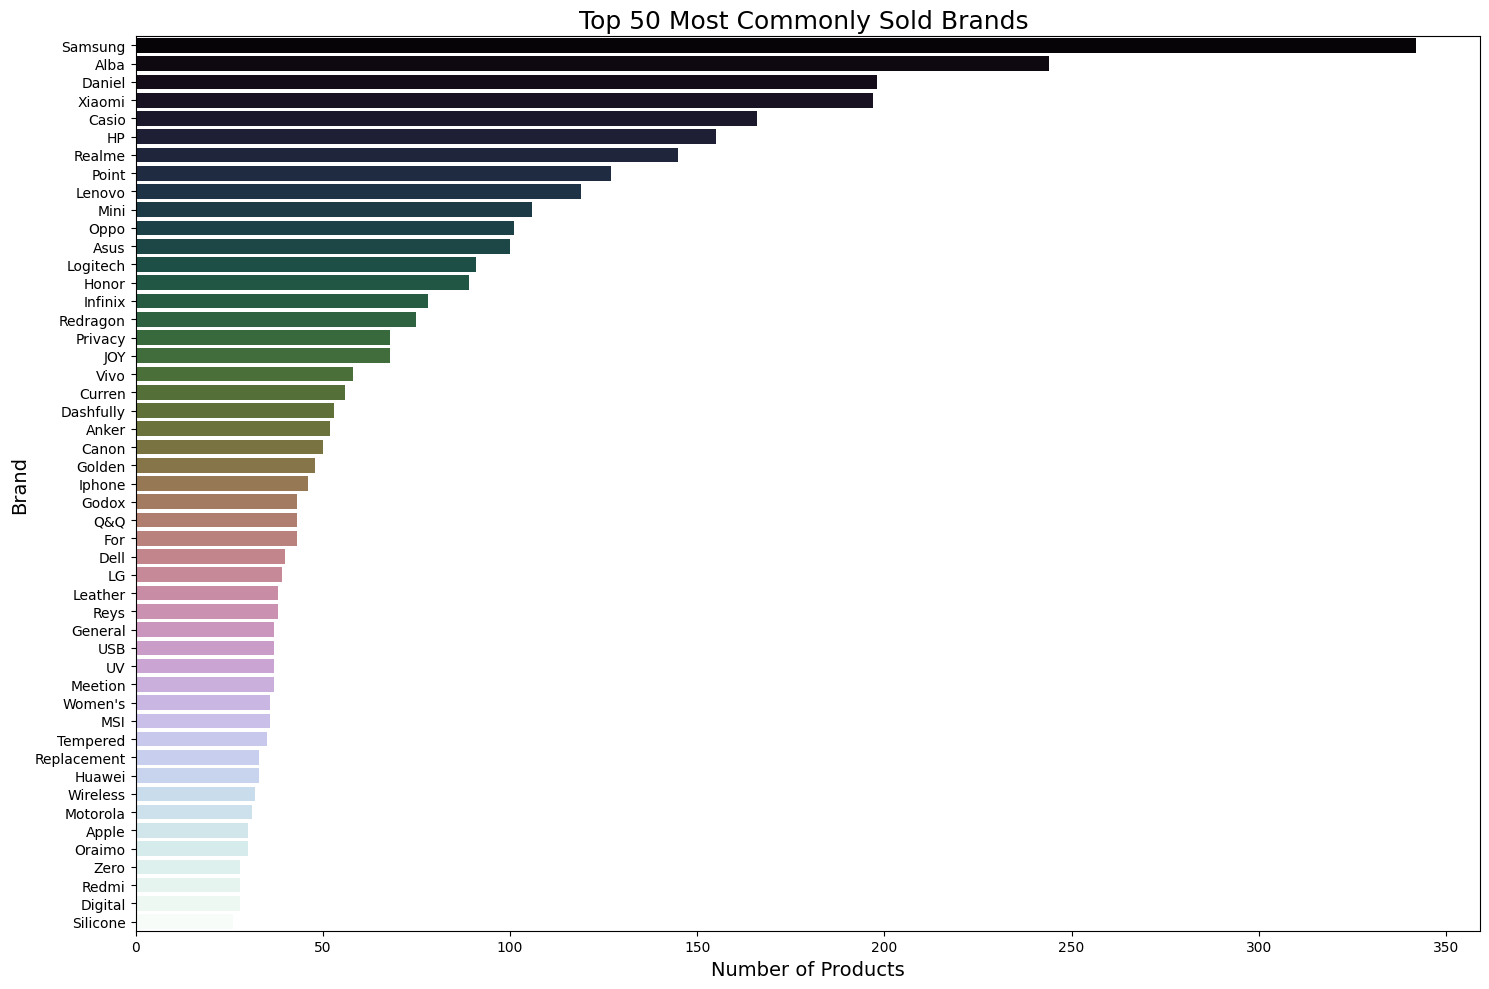

In [43]:
# Step 1: Get top 50 brands
top_brands = df['brand'].value_counts().nlargest(50).index

# Step 2: Replace all brands not in top 50 with 'Other'
df['brand'] = df['brand'].apply(lambda x: x if x in top_brands else 'Other')

# Step 3: Count and sort values
brand_counts = df['brand'].value_counts().sort_values(ascending=False)

# Step 4: Remove 'Other' and 'unknown' from the counts
brand_counts = brand_counts[~brand_counts.index.str.lower().isin(['other', 'unknown'])]

# --- Seaborn Bar Plot ---
plt.figure(figsize=(15, 10))
sns.barplot(x=brand_counts.values, y=brand_counts.index, palette="cubehelix")
plt.title("Top 50 Most Commonly Sold Brands ", fontsize=18)
plt.xlabel("Number of Products", fontsize=14)
plt.ylabel("Brand", fontsize=14)
plt.tight_layout()
plt.show()

## shows brands whose best-selling products

In [44]:
# Recreate the DataFrame with value counts and percentages
category_counts = df['category'].value_counts()
category_percentages = (category_counts / len(df)) * 100
category_df = category_percentages.reset_index()
category_df.columns = ['Category', 'Percentage']

# Create the pie chart using Plotly
fig = px.pie(
    category_df,
    names='Category',
    values='Percentage',
    title='Product Distribution by Category',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
    template='plotly_dark'
)

# Customize trace appearance
fig.update_traces(
    textinfo='percent+label',
    pull=[0.05] * len(category_df)  # slight pull for all slices
)

fig.show()

### The pie chart visually highlights the largest size of computing-accessories and mobile-accessories but kitchen-appliances (0.59%) is nearly invisible

In [45]:
fig = px.histogram(
    df,
    x='rating',
    nbins=5,
    title="Distribution of rating",
    template='plotly_dark'
)

fig.update_layout(
    xaxis_title='rating',
    yaxis_title='Count',
    height=400,
    bargap=0.1
)

fig.show()

### The distribution is `Left-skewed`, with higher ratings (4 and 5) being more frequent.

### **Price Analysis**

In [46]:
grouped_data = []
labels = []

for category in df['category'].unique():
    category_data = df[df['category'] == category]['log_price'].dropna().tolist()
    if category_data:  # Ensure there's data in the list
        grouped_data.append(category_data)
        labels.append(f"{category}")

# Create KDE plot
kde_fig = ff.create_distplot(
    grouped_data,
    group_labels=labels,
    colors=px.colors.qualitative.Pastel,
    show_hist=False,
    show_rug=False
)

kde_fig.update_layout(title="KDE Plot of Log-Price by Category", template='plotly_dark')
kde_fig.show()

### Insights from KDE Plot of Log-Price by Category

* **Smartphones:** Exhibit the highest average log-price, peaking around a log-price of 10, suggesting they are generally the most expensive items after the log transformation.
* **Laptops:** Also show a relatively high average log-price, with a peak slightly below smartphones, around a log-price of 9.5.
* **Televisions:** Display a bimodal distribution with peaks around log-prices of 8.5 and 10, indicating two distinct price ranges within this category.
* **Cameras:** Show a broad distribution with a peak around a log-price of 8, suggesting a wider range of prices compared to smartphones and laptops.
* **Computing-accessories:** Have a distribution centered around a log-price of 5, indicating they are generally less expensive.
* **Mobile-accessories:** Tend to be on the lower end of the price spectrum, with a peak around a log-price of 4.5.
* **Kitchen-appliances:** Have a distribution peaking around a log-price of 5, similar to computing accessories.
* **Women-watches:** Display a distribution with a peak around a log-price of 6, placing them in a mid-range price category.


In [47]:
# Define category-specific thresholds based on the KDE plot
category_thresholds = {
    'cameras': {'low': 6.0, 'medium': 8.0},
    'computing-accessories': {'low': 5.5, 'medium': 7.5},
    'mobile-accessories': {'low': 4.0, 'medium': 6.0},
    'women-watches': {'low': 5.0, 'medium': 7.0},
    'kitchen-appliances': {'low': 5.0, 'medium': 7.0},
    'televisions': {'low': 7.0, 'medium': 9.0},
    'laptops': {'low': 7.5, 'medium': 9.5},
    'smartphones': {'low': 7.0, 'medium': 9.0}
}

def categorize_price(row):
    category = row['category']  # assuming you have a 'category' column
    price = row['price']
    log_price = np.log(price)

    thresholds = category_thresholds.get(category, {'low': 5.5, 'medium': 7.5})

    if log_price < thresholds['low']:
        return 'low'
    elif log_price < thresholds['medium']:
        return 'medium'
    else:
        return 'high'

# Apply the categorization
df['price_category'] = df.apply(categorize_price, axis=1)

# Verify the results
print(df[['category', 'price', 'price_category']].head())

      category   price price_category
0  smartphones  5499.0         medium
1  smartphones  7850.0         medium
2  smartphones  9250.0           high
3  smartphones  6199.0         medium
4  smartphones  7199.0         medium


In [48]:
def get_price_ranges_actual_egp(df, category_col='category', price_col='price'):
    """
    Calculate low/medium/high price ranges in actual EGP (no log transformation)

    Returns:
        - DataFrame with price ranges
        - Dictionary of thresholds for categorization
    """
    results = []
    threshold_dict = {}

    for category in df[category_col].unique():
        # Get prices for this category
        prices = df[df[category_col] == category][price_col]
        prices = prices[prices > 0]  # Remove invalid prices

        # Calculate direct percentiles in EGP
        low_max = prices.quantile(0.33)
        medium_max = prices.quantile(0.66)

        # Store results
        results.append({
            'category': category,
            'low_range': f"< {low_max:,.2f} EGP",
            'medium_range': f"{low_max:,.2f} - {medium_max:,.2f} EGP",
            'high_range': f">= {medium_max:,.2f} EGP",
            'low_threshold': low_max,
            'medium_threshold': medium_max
        })

        threshold_dict[category] = {
            'low_max': low_max,
            'medium_max': medium_max
        }

    return pd.DataFrame(results), threshold_dict

# Usage
price_ranges, thresholds = get_price_ranges_actual_egp(df)

print("Price Ranges by Category (EGP):")
display(price_ranges[['category', 'low_range', 'medium_range', 'high_range']])


Price Ranges by Category (EGP):


,category,low_range,medium_range,high_range
0,smartphones,"< 6,401.40 EGP","6,401.40 - 9,000.00 EGP",">= 9,000.00 EGP"
1,laptops,"< 27,999.00 EGP","27,999.00 - 42,029.00 EGP",">= 42,029.00 EGP"
2,televisions,"< 9,999.00 EGP","9,999.00 - 19,495.08 EGP",">= 19,495.08 EGP"
3,kitchen-appliances,< 29.08 EGP,29.08 - 347.00 EGP,>= 347.00 EGP
4,women-watches,"< 1,500.00 EGP","1,500.00 - 3,618.28 EGP",">= 3,618.28 EGP"
5,mobile-accessories,< 110.00 EGP,110.00 - 199.00 EGP,>= 199.00 EGP
6,computing-accessories,< 240.00 EGP,240.00 - 650.00 EGP,>= 650.00 EGP
7,cameras,"< 1,999.00 EGP","1,999.00 - 9,999.00 EGP",">= 9,999.00 EGP"


In [49]:
# Recreate the DataFrame with value counts and percentages
category_counts = df['price_category'].value_counts()
category_percentages = (category_counts / len(df)) * 100
price_category_df = category_percentages.reset_index()
price_category_df.columns = ['Price Category', 'Percentage']

# Create the pie chart in the same style
fig = px.pie(
    price_category_df,
    names='Price Category',
    values='Percentage',
    title=' Product Distribution by Price Category',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
    template='plotly_dark'
)

# Customize trace appearance
fig.update_traces(
    textinfo='percent+label',
    pull=[0.05] * len(price_category_df)  # add a small pull for all slices
)

fig.show()

In [50]:
price_by_category = df.groupby("category")["log_price"].mean()

fig = px.bar(price_by_category,
             x=price_by_category.index,
             y=price_by_category.values,
             labels={'x': 'category', 'y': 'sales'},
             title="Total Sales by category")

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(color='white'),
    xaxis_title='category',
    yaxis_title='Sales',
)

fig.show()

### 🔍 Key Observations:
- **💻 Laptops** are the top-selling category by a significant margin.
- **📺 Televisions** and **📷 Cameras** also show strong sales, indicating high demand in the electronics segment.
- **📱 Smartphones** generate moderate sales, potentially benefiting from more targeted promotions.
- **🔌 Accessories** such as *computing-accessories*, *mobile-accessories*, and *kitchen-appliances* show very low sales.
- **⌚ Women-watches** have relatively low sales, possibly due to limited demand or poor visibility.

In [51]:
top_brands = df['brand'].value_counts().nlargest(20).index
df['brand'] = df['brand'].apply(lambda x: x if x in top_brands else 'Other')
filtered_df = df[~df['brand'].str.lower().isin(['other', 'unknown'])]
brand_price_sum = filtered_df.groupby('brand')['price'].sum().sort_values(ascending=False)

# Reset index for Plotly
brand_price_df = brand_price_sum.reset_index()
brand_price_df.columns = ['Brand', 'Total Sales']

# --- Plotly Vertical Bar Chart ---
fig = px.bar(
    brand_price_df,
    x='Brand',
    y='Total Sales',
    text='Total Sales',
    title='Total Sales for Top 20 Brands',
    color='Total Sales',
    color_continuous_scale='magma',
    template='plotly_white'
)

# Format hover and text
fig.update_traces(
    texttemplate='%{text:,.0f}',
    textposition='outside'
)
fig.update_layout(
    xaxis_title='Brand',
    yaxis_title='Total Sales',
    xaxis_tickangle=-45,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=700
)

fig.show()

## **Discount Analysis**

In [52]:
# This calculates how much discount is being given on each product
df['price_ratio'] = df['price'] / df['original_price']

In [53]:
df.head()

,name,price,original_price,discount,rating,review_count,brand,category,log_price,log_original_price,log_review_count,log_discount,price_category,price_ratio
0,Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G M...,5499.0,7148.7,23.08,4.1,16.0,Samsung,smartphones,8.612503,8.874826,2.833213,3.181382,medium,0.769231
1,"Samsung Galaxy A16 - 6.7"" 128GB/6GB Dual SIM 4...",7850.0,9420.0,16.67,4.0,33.0,Samsung,smartphones,8.968396,9.150697,3.526361,2.871868,medium,0.833333
2,"Samsung Galaxy A16 - 6.7"" 256GB/8GB Dual SIM 4...",9250.0,11100.0,16.67,4.4,18.0,Samsung,smartphones,9.132487,9.314790,2.944439,2.871868,high,0.833333
3,Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G M...,6199.0,8058.7,23.08,3.9,22.0,Samsung,smartphones,8.732305,8.994632,3.135494,3.181382,medium,0.769231
4,"Samsung Galaxy A16 - 6.7"" 128GB/4GB Dual SIM 4...",7199.0,9358.7,23.08,4.6,9.0,Samsung,smartphones,8.881836,9.144169,2.302585,3.181382,medium,0.769231


In [54]:
# KDE for price
ff_fig = ff.create_distplot([df['price_ratio']], group_labels=['price_ratio'], colors=['#FFA07A'], show_hist=True)
ff_fig.update_layout(title="KDE Plot of Log-Price", template='plotly_dark')
ff_fig.show()

## `The KDE` shows that most of products have high ratio(low discount) and few of them have low ratio(high discount) , so it's lift_skewed based on this I choose the threshold that represent 25% percentile to indicate that few of data (outliers) has high discount.

In [55]:
# Calculate the threshold (Q3) from review_count
threshold = df['price_ratio'].quantile(0.25)
threshold

0.66

In [56]:
# Filter the high and low discounts based on the threshold
high_discount = df[df['price_ratio'] <= threshold]['discount']
low_discount = df[df['price_ratio'] > threshold]['discount']

# Print the starting values of high and low discounts
print("Starting Value for High Discount:")
print(high_discount.min())  # The lowest high discount
print("\nEnding Value for Low Discount:")
print(low_discount.max())  # The highest low discount

Starting Value for High Discount:
34.0

Ending Value for Low Discount:
33.93


## That is means less than 34% is low discount and above is high.

In [57]:
df['price_ratio_category'] = df['price_ratio'].apply(lambda x: 'low discount' if x > threshold else 'high discount')

In [58]:
# Recreate the DataFrame with value counts and percentages
category_counts = df['price_ratio_category'].value_counts()
category_percentages = (category_counts / len(df)) * 100
price_ratio_category_df = category_percentages.reset_index()
price_ratio_category_df.columns = ['Price ratio Category', 'Percentage']

# Create the pie chart in the same style
fig = px.pie(
    price_ratio_category_df,
    names='Price ratio Category',
    values='Percentage',
    title=' Product Discount',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
    template='plotly_dark'
)

# Customize trace appearance
fig.update_traces(
    textinfo='percent+label',
    pull=[0.05] * len(price_category_df)  # add a small pull for all slices
)

fig.show()

## This ensures that high discount products are few representing 25% of the data.

In [59]:
# 3. Group by price_ratio_category and sum sales
price_by_ratio = df.groupby('price_ratio_category')['price'].sum().reset_index()

fig = px.bar(
    price_by_ratio,
    x='price_ratio_category',
    y='price',
    title='Total Sales by Price Ratio Category',
    labels={'price': 'Total Sales (EGP)', 'price_ratio_category': 'Price Ratio Category'},
    color='price_ratio_category',
    color_discrete_sequence=px.colors.sequential.RdBu
)
fig.update_layout(template='plotly_dark')
fig.show()

## That is because just few products have high discounts so the sales is seems few

## **Best Seller Analysis:**

In [60]:
# Calculate the threshold (Q3) from review_count
threshold = df['review_count'].quantile(0.75)

# The first np.where checks for missing values (isna()), second np.where assigns 'high' or 'low' based on the threshold.
df['review_category'] = np.where(
    df['review_count'].isna(), np.nan,
    np.where(df['review_count'] >= threshold, 'high', 'low')
)

In [61]:
# Filter out missing values first
valid_reviews = df.dropna(subset=['review_count'])

# Get counts and percentages
counts = valid_reviews['review_category'].value_counts()
percentages = valid_reviews['review_category'].value_counts(normalize=True).mul(100).round(1) #normalize converts counts to proportions (0.75 for 75%)
print("Review Distribution (Excluding Missing):")                                          #mul().round() converts proportions to percentages (e.g., 75.0%)

print("--------------------------------------")
print(f"High Reviews (≥{threshold:.0f}): {counts.get('high', 0)} items ({percentages.get('high', 0)}%)")
print(f"Low Reviews (<{threshold:.0f}): {counts.get('low', 0)} items ({percentages.get('low', 0)}%)")

Review Distribution (Excluding Missing):
--------------------------------------
High Reviews (≥9): 656 items (26.5%)
Low Reviews (<9): 1815 items (73.5%)


In [62]:
fig = px.violin(
    df.dropna(subset=['review_category']),  # Exclude NaN categories from plot
    x="review_category",
    y=np.log1p(df["review_count"]),
    box=True,
    points=False,
    color="review_category",
    color_discrete_sequence=["#2E8B57", "#4169E1"],
    title=f"Review Count Distribution (Threshold={threshold:.0f} reviews)" if not np.isnan(threshold) else "Review Count Distribution",
    template="plotly_dark",
    category_orders={"review_category": ["low", "high"]}
)

# Customize layout
fig.update_layout(
    xaxis_title="Review Category (NaN values excluded)",
    yaxis_title="Log(Review Count + 1)",
    showlegend=False
)

# Only add threshold line if calculation succeeded
if not np.isnan(threshold):
    fig.add_hline(
        y=np.log1p(threshold),
        line_dash="dot",
        line_color="red",
        annotation_text=f"Threshold: {threshold:.0f} reviews",
        annotation_position="top right"
    )

fig.show()

# Show NaN count for transparency
nan_count = df['review_count'].isna().sum()
print(f"Preserved {nan_count} NaN values (excluded from analysis)")

Preserved 4258 NaN values (excluded from analysis)


### most have low review but there are extreme high reviews

In [63]:
#  Engagement score
df['engagement_score'] = df['rating'] * np.log1p(df['review_count'])

### Multiplication (rating * log1p(review_count)):
### A higher rating increases the score, higher review_count also increases the score, but with diminishing returns due to the logarithm.

### The log1p function is used to Smooth the impact of very high review counts (to prevent items with thousands of reviews from dominating purely due to volume).

In [64]:
# to convert the range into 0 and 1.
scaler = MinMaxScaler()
df[['norm_engagement']] = scaler.fit_transform(df[['engagement_score']])

df['best_seller_score'] = df['norm_engagement']
# choosing only top 10% of the high scores
threshold = df['best_seller_score'].quantile(0.90)

df['is_best_seller'] = df['best_seller_score'] >= threshold

best_sellers = df[df['is_best_seller']].sort_values(by='best_seller_score', ascending=False)

print(f"Total Best Sellers Identified: {best_sellers.shape[0]}")
display(best_sellers[['name', 'brand', 'category', 'engagement_score', 'best_seller_score']].head(10))

Total Best Sellers Identified: 249


,name,brand,category,engagement_score,best_seller_score
1395,HOHO Stainless Steel Electric Kettle - 1.5L - ...,Other,kitchen-appliances,34.370201,1.000000
1113,HOHO 32-Inch HD LED Standard TV HK 3205 Black,Other,televisions,33.184230,0.964784
3546,Apple AirPods (2nd Generation) with Charging Case,Other,mobile-accessories,26.906894,0.778386
1108,HOHO 43-inch Full HD LED TV HK4305 Piano Black,Other,televisions,26.255422,0.759041
2889,Ring Light - 26 CM + Metal Stand - 210 Cm - Wh...,Other,mobile-accessories,25.261432,0.729526
4562,Logitech M171 Wireless Mouse - Black,Logitech,computing-accessories,25.018147,0.722302
1360,Samsung 32T5300AUXEG - 32 Inch HD Smart LED TV...,Samsung,televisions,23.984569,0.691611
1086,Samsung UA32T5300 - 32-inch HD Smart TV With B...,Samsung,televisions,23.984569,0.691611
2941,JOY ROOM JR- OK3 Rotation & Adjustable Length ...,JOY,mobile-accessories,23.725692,0.683924
1111,HOHO 43-Inch Full HD Smart LED TV HK4305S1 Black,Other,televisions,23.637823,0.681315


In [65]:
# Step 1: Get the top 10 best sellers sorted by engagement
top_10 = df[df['is_best_seller']].sort_values(by='engagement_score', ascending=False).head(10)

# Step 2: Create bar chart
fig = px.bar(
    top_10,
    x='name',
    y='engagement_score',
    color='brand',
    title='Top 10 Best Seller Products by Engagement Score',
    labels={'name': 'Product Name', 'engagement_score': 'Engagement Score'},
    text='engagement_score'
)

# Step 3: Improve layout
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45, yaxis=dict(title='Engagement Score'))

fig.show()

###  Top 10 `best sellers` in the store

In [66]:
# Filter best sellers in smartphones category
best_sellers_smartphones = df[(df['is_best_seller']) & (df['category'] == 'smartphones')].sort_values(by='best_seller_score', ascending=False)

#  Display the results
print(f"Total Best Sellers in SmartPhones Category: {best_sellers_smartphones.shape[0]}")
display(best_sellers_smartphones[['name', 'brand', 'category', 'engagement_score', 'best_seller_score']])


Total Best Sellers in SmartPhones Category: 22


,name,brand,category,engagement_score,best_seller_score
150,Samsung Galaxy A15 - 6.5-inch 4GB/128GB Dual S...,Samsung,smartphones,21.517536,0.618355
96,"Samsung Galaxy A05s - 6.7"" 64GB/4GB Dual SIM 4...",Samsung,smartphones,18.500648,0.528773
166,Samsung Galaxy A16 - 6.7-inch 6GB/128GB Dual S...,Samsung,smartphones,17.129981,0.488072
67,"OPPO Reno 12F - 6.6"" 256GB/12GB Dual SIM 5G Ph...",Oppo,smartphones,16.846022,0.479640
118,"Samsung Galaxy A05s - 6.7"" 64GB/4GB - Dual SIM...",Samsung,smartphones,16.717904,0.475836
14,"XIAOMI Redmi Note 13 - 6.6""Inch 128GB/6GB Dual...",Xiaomi,smartphones,15.985628,0.454092
649,Samsung Galaxy A15 - 6.5 Inch Dual SIM 4G 128G...,Samsung,smartphones,15.893596,0.451359
57,Redmi A3 4GB RAM 128GB ROM MIDNIGHT BLACK,Other,smartphones,15.868622,0.450618
91,XIAOMI Redmi 13C - 6.74-inch 8GB/256GB Dual Si...,Xiaomi,smartphones,15.526947,0.440472
178,XIAOMI Redmi 12 Dual SIM 4G 128GB/8GB - Midnig...,Xiaomi,smartphones,15.490433,0.439388


### `Best sellers` in `SmartPhones`

---
---

## **MongoDB:**

### Storing Processed Dataset into MongoDB Atlas (online cloud MongoDB)

### *Goal Overview*

- Connecting to a **MongoDB Atlas** database using Python (`pymongo`).
- Preparing our **processed and cleaned dataset** using **Pandas**.
- Converting the dataset into a format compatible with MongoDB.
- **Inserting** the structured data into a MongoDB **collection**.
- Optionally **verifying** the inserted records.

###  *Tools and Libraries*
- Python
- Pandas
- PyMongo
- MongoDB Atlas (Cloud-hosted NoSQL Database)

---


### pip install pymongo ->  on the terminal

In [ ]:
from pymongo import MongoClient

###### Step 1: Connect to MongoDB (localhost on default port 27017)
client = MongoClient("mongodb://localhost:27017/")

###### Step 2: Create/get your database and collection
db = client["Project"]            # Replace with your desired DB name
collection = db["DS_Tools"]      # Replace with your desired collection name

###### Step 3: Convert DataFrame to a list of dictionaries (MongoDB documents)
data_dict = df.to_dict("records")

data_dict = df.to_dict("records")


In [ ]:
###### Step 4: Insert the list of documents into MongoDB
collection.insert_many(data_dict)

###### Step 5: Print confirmation
print("DataFrame saved to MongoDB successfully.")

---
---

## **Recommender System:**

###**Approach:**

**Content-based filtering:** Recommends items similar to what a user likes based on item features

---

#### **Features we'll use:**

* Product name (description)

* Category

* Brand

---

### **Preparing the DataSet**

In [67]:
#show full row length
pd.set_option('display.max_colwidth', None)

recommender_df = df[['category','brand','name','price','rating','discount','original_price']]
recommender_df['product_id'] = range(len(df))  # Unique ID
recommender_df.sample(10)

,category,brand,name,price,rating,discount,original_price,product_id
768,laptops,Asus,Asus TUF Gaming A15 FA506NFR-HN007W AMD Ryzen 7 7435HS 512GB SSD 8GB Ram Nvidia GeForce RTX 2050 4GB 15.6'' Inch FHD Win.11,31800.0,NaN,10.42,35499.000000,768
5876,computing-accessories,Other,Rapoo C280 - 2K HD USB2.0 Mic Rotatable Webcam,2799.0,NaN,24.00,3682.894737,5876
5198,computing-accessories,Logitech,Logitech USB Headset H540 for PC Calls and Music - Black,2400.0,5.0,19.97,2999.000000,5198
82,smartphones,Samsung,"Samsung Galaxy A05s - 6.7"" 64GB/4GB Dual SIM 4G Mobile Phone - Violet",5445.0,3.6,8.10,5925.000000,82
4517,mobile-accessories,Privacy,Privacy Screen Protector Full Curve For Xiaomi Redmi Note 10 5G - 0 - Black,89.0,4.7,12.50,101.714286,4517
2282,women-watches,Alba,"Alba Ladies' PRESTIGE Stainless Steel Bracelet , Silver Dial AH7W41X5",3940.0,NaN,24.95,5250.000000,2282
3345,mobile-accessories,Other,For Samsung Galaxy Note 9 Nano Optics Curved Liquid Full Glue Glass Protector With UV Light Dryer Fingerprint Unlock Fast -0- Clear,174.0,3.8,16.67,208.808352,3345
5277,computing-accessories,Other,VABi VABICABLE USB TO LIGHTNING-(CA42) 1M,190.0,NaN,0.00,190.000000,5277
6058,computing-accessories,Other,Super Bright Bike Light Set USB Rechargeable,1990.0,NaN,17.08,2400.000000,6058
6594,cameras,Other,Godox 60*60 SB-BW,599.0,1.0,20.02,748.937234,6594


In [68]:
# Create a combined text feature for similarity analysis
recommender_df['combined_features'] = recommender_df['brand'] + ' ' + recommender_df['category'] + ' ' + recommender_df['name']
recommender_df['combined_features'].head()

0                                                            Samsung smartphones Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G Mobile Phone - Black
1    Samsung smartphones Samsung Galaxy A16 - 6.7" 128GB/6GB Dual SIM 4G Mobile Phone - Black + Free 25W Adapter USB-C Super Fast Charging - Black
2    Samsung smartphones Samsung Galaxy A16 - 6.7" 256GB/8GB Dual SIM 4G Mobile Phone - Black + Free 25W Adapter USB-C Super Fast Charging - Black
3                                                            Samsung smartphones Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G Mobile Phone - Black
4    Samsung smartphones Samsung Galaxy A16 - 6.7" 128GB/4GB Dual SIM 4G Mobile Phone - Black + Free 25W Adapter USB-C Super Fast Charging - Black
Name: combined_features, dtype: object

---

### **Algorithm used:**

 **TF-IDF** **Term Frequency – Inverse Document Frequency**. a popular technique used in **natural language processing (NLP)** to turn text into numbers—so that machine learning algorithms can work with it.

---

### **Overview:**

TF-IDF tells you **how important a word is to a document** in a collection of documents.

##### **It has two parts:**

1. #### **TF – Term Frequency**
   This measures how often a word appears in a document.

   $$
   \text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in } d}
   $$

   Example:
   - In a product description: _"Red shoes for running."_
   - The word **"red"** appears once.
   - There are 4 words total.
   - TF of "red" = 1 / 4 = **0.25**

   ---

2. #### **IDF – Inverse Document Frequency**
   This reduces the weight of common words that appear in **many documents**.

   $$
   \text{IDF}(t) = \log \left(\frac{\text{Total number of documents}}{\text{Number of documents containing } t} \right)
   $$

   - If a word like **"the"** appears in every product, it's not useful.
   - But if **"ultraboost"** appears in only a few—it's more unique and meaningful.

---

#### **TF-IDF = TF × IDF**
This gives higher scores to words that are:
- **frequent in one document** (product description)
- **rare across the whole dataset**

---

#### **Why TF-IDF is often used in Recommender Analysis ?**
- It helps **capture important keywords** in product descriptions.
- It builds a **vector for each product** that reflects its unique text content.
- You can compare products using **cosine similarity** of these vectors.


---

### **Preprocessing and Vectorization**

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')

# Fit and transform the combined features
tfidf_matrix = tfidf.fit_transform(recommender_df['combined_features'])

#Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

####  TF-IDF Matrix Illustrative Output Example:

|        | XIAOMI |  | Itel | Lenovo | HP |  | Apple | USB |
|--------|------|-------------|-------|------|-----|---------|--------|----------|
| Doc 0 | 0.00 | 0.00 | 0.00 | 0.00 | 0.71 | 0.50 | 0.50 | 0.00 |
| Doc 1 | 0.71 | 0.00 | 0.00 | 0.00 | 0.00 | 0.50 | 0.50 | 0.00 |
| Doc 2 | 0.00 | 0.00 | 0.71 | 0.71 | 0.57 | 0.00 | 0.00 | 0.00 |
| Doc 3 | 0.00 | 0.71 | 0.00 | 0.00 | 0.00 | 0.54 | 0.00 | 0.71 |

Where:
- Each **row** is a product.
- Each **column** is a word from all descriptions.
- Each **value** is the TF-IDF score: how important that word is to that product.


---

### **Functions used For Building The Recommender:**

There are **2** main **fuctions**:
1. Input Processing Function --->  `process_user_input(user_input, df)`
2. Enhanced Recommendation Function ---> `get_enhanced_recommendations(user_input, df, cosine_sim, n)`

---

### **Input Processing Function**

Handeles user input by:

1. **Normalization**:Input is converted to lowercase and stripped of any leading or trailing whitespace to ensure consistency during comparison.

2. **Partial Name Matching**: Checks if the input appears as a substring in any product name, allowing for partial or shorthand product name searches (e.g., "galaxy" matching "Samsung Galaxy A06").

3. **Exact Brand and Category Matching**: If no relevant names are found, the function checks for exact matches in the brand and category columns. This allows users to search by known brands (e.g., "apple") or product categories (e.g., "smartphones").

4. **Fallback Fuzzy Matching via Model Numbers**: If no results are found using the above methods, the function attempts a lightweight fuzzy match by scanning product names for model-like patterns (e.g., "A06", "x200") and comparing them to the user input. This helps retrieve products even if users search using only technical identifiers.

5. **Duplicate Removal**: Finally, the list of matched product IDs is converted to a set to eliminate duplicates and returned as a clean list of results.

This multi-layered input processing ensures robust matching performance and improves user experience by handling a wide range of search inputs.

---

In [70]:
import re

def process_user_input(user_input, recommender_df):
    """
    Process user input to find the most relevant product matches
    Handles shorthand names, brands, or categories
    """
    # Normalize input
    user_input = user_input.lower().strip()

    # Initialize results
    matches = []

    # Check if input matches any product's full name (partial match)
    name_matches = recommender_df[recommender_df['name'].str.lower().str.contains(user_input, regex=False)]
    if not name_matches.empty:
        matches.extend(name_matches['product_id'].tolist())

    # Check if input matches any brand
    brand_matches = recommender_df[recommender_df['brand'].str.lower() == user_input]
    if not brand_matches.empty:
        matches.extend(brand_matches['product_id'].tolist())

    # Check if input matches any category
    category_matches = recommender_df[recommender_df['category'].str.lower() == user_input]
    if not category_matches.empty:
        matches.extend(category_matches['product_id'].tolist())

    # If no matches found, try fuzzy matching on product names
    if not matches:
        for idx, row in recommender_df.iterrows():
            # Extract model number/identifier if exists (e.g., "A06" from "Samsung Galaxy A06")
            model_num = re.search(r'(\b[a-z]\d+\b)', row['name'].lower())
            if model_num and user_input in model_num.group(1):
                matches.append(row['product_id'])

    return list(set(matches))  # Remove duplicates

### **Enhanced Recommendation Function**

The `get_enhanced_recommendations` function is designed to improve the accuracy and flexibility of product recommendations by combining **fuzzy string matching** with **content-based filtering** using **cosine similarity**. This enhanced approach helps handle **misspellings**, **partial matches**, and **ambiguous user inputs** related to product names, brands, or categories.

#### **Key Features:**
1. **Input Normalization & Matching**:
   - First, the function tries to identify matching products using exact or partial matches via a helper function (`process_user_input`).
   - If no exact matches are found, it performs **fuzzy matching** (using `fuzzywuzzy`) to find the closest matching brand or category, ensuring that even incorrect or incomplete inputs can yield relevant results.

2. **Search Context Detection**:
   - The function analyzes whether the input resembles a **brand**, **category**, or **product name** to intelligently filter the search scope. This ensures the recommendation engine focuses on the most relevant subset of the dataset.

3. **Content-Based Recommendation**:
   - Using the precomputed **cosine similarity matrix**, the function calculates similarity scores between matched products and others in the filtered subset.
   - It selects top products based on similarity scores while avoiding duplicates.

4. **Final Output**:
   - Returns a ranked list of up to `top_n` recommended products in a pandas DataFrame.
   - If no suitable match is found, a user-friendly message is returned.

#### **Benefits:**
- Enhances robustness of the recommender system against user input errors.
- Combines exact and approximate search for improved user experience.
- Efficiently narrows down recommendations using contextual relevance.

---


In [71]:
#!pip install fuzzywuzzy
from fuzzywuzzy import fuzz, process

def get_enhanced_recommendations(user_input, recommender_df, cosine_sim, top_n=5):
    """
    Enhanced recommender with fuzzy matching for brands/categories
    - Handles typos and partial matches
    """
    # Helper function for fuzzy matching
    def get_best_match(input_str, options, threshold=70):
        match = process.extractOne(input_str.lower(),
                                 [str(x).lower() for x in options],
                                 scorer=fuzz.token_set_ratio,
                                 score_cutoff=threshold)
        return match[0] if match else None

    # 1. Find matching products (exact + fuzzy)
    user_input_lower = user_input.lower().strip()
    matched_product_ids = process_user_input(user_input, recommender_df)

    # If no exact matches, try fuzzy matching on brand/category
    if not matched_product_ids:
        best_brand = get_best_match(user_input, recommender_df['brand'].unique())
        best_category = get_best_match(user_input, recommender_df['category'].unique())

        # Determine which fuzzy match is better
        if best_brand and best_category:
            brand_score = fuzz.token_set_ratio(user_input_lower, best_brand.lower())
            category_score = fuzz.token_set_ratio(user_input_lower, best_category.lower())
            best_match = best_brand if brand_score > category_score else best_category
        else:
            best_match = best_brand or best_category

        if best_match:
            if best_match.lower() in [b.lower() for b in recommender_df['brand'].unique()]:
                matched_product_ids = recommender_df[recommender_df['brand'].str.lower() == best_match.lower()]['product_id'].tolist()
            else:
                matched_product_ids = recommender_df[recommender_df['category'].str.lower() == best_match.lower()]['product_id'].tolist()
        else:
            return "No products found matching your input. Please try a different search term."

    # 2. Determine search context (brand/category/product)
    indices = [recommender_df[recommender_df['product_id'] == pid].index[0] for pid in matched_product_ids]

    # Check if input matches a brand or category (with fuzzy matching)
    best_brand = get_best_match(user_input, recommender_df['brand'].unique())
    best_category = get_best_match(user_input, recommender_df['category'].unique())

    # Determine subset of products to consider
    if best_brand and (not best_category or
                      fuzz.token_set_ratio(user_input_lower, best_brand.lower()) >=
                      fuzz.token_set_ratio(user_input_lower, best_category.lower())):
        subset_df = recommender_df[recommender_df['brand'].str.lower() == best_brand.lower()]
    elif best_category:
        subset_df = recommender_df[recommender_df['category'].str.lower() == best_category.lower()]
    else:
        subset_df = recommender_df

    # 3. Generate recommendations
    recommendation_scores = {}
    subset_indices = subset_df.index.tolist()

    for idx in indices:
        sim_scores = list(enumerate(cosine_sim[idx]))
        for subset_idx in subset_indices:
            score = sim_scores[subset_idx][1]
            if subset_idx not in recommendation_scores or score > recommendation_scores[subset_idx]:
                recommendation_scores[subset_idx] = score

    # 4. Filter and return results
    recommended_products = []
    seen_products = set()

    for i, _ in sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True):
        product = recommender_df.iloc[i]
        if product['product_id'] not in seen_products:
            recommended_products.append(product)
            seen_products.add(product['product_id'])
            if len(recommended_products) >= top_n:
                break

    return pd.DataFrame(recommended_products) if recommended_products else "No relevant recommendations found."

c:\Users\u s e r\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



### **Testing The Recommender**

**Recommendation System Test Cases**

Testing the enhanced recommendation system using various types of user inputs:
  
 *  **Test 1**: Search by shorthand product names
    - Verifies if the system can handle partial names like "Samsung A06" or "Redmi Note".

* **Test 2**: Search by product type (category-like input)
    - Checks if the system returns relevant items for general terms like "kettle" or "PowerBank".

* **Test 3**: Search by brand name only
    - Validates brand-based filtering with inputs like "Beko" or "lg".

* **Test 4**: Search by category
    - Confirms that category-specific inputs like "Kitchen" or "watches" return matching products.

*  **Test 5**: Search with typos or misspellings
    - Tests fuzzy matching robustness with misspelled inputs like "smsng" or "samartphns".

*  **Test 6**: Search with no valid matches
    - Evaluates how the system handles completely irrelevant or non-existent brands/products like "Gucci" or "Nonexistent".

All the while ensuring the case sensitivity handelling..

---


In [72]:
# Test 1: Search by shorthand name
print("Recommendations for 'Samsung A06':")
print(get_enhanced_recommendations("Samsung A06", recommender_df, cosine_sim,10))
print('-------------------------------------------------')

print("\nRecommendations for 'Redmi Note':")
print(get_enhanced_recommendations("Redmi Note", recommender_df, cosine_sim))
print('-------------------------------------------------')

# Test 2: Search by product type
print("\nRecommendations for 'kettle':")
print(get_enhanced_recommendations("kettle", recommender_df, cosine_sim, 2))
print('-------------------------------------------------')

print("\nRecommendations for 'PowerBank':")
print(get_enhanced_recommendations("PowerBank", recommender_df, cosine_sim))
print('-------------------------------------------------')

# Test 2: Search by brand only
print("\nRecommendations for 'Beko':")
print(get_enhanced_recommendations("Beko", recommender_df, cosine_sim))
print('-------------------------------------------------')

print("\nRecommendations for 'lg':")
print(get_enhanced_recommendations("lg", recommender_df, cosine_sim))
print('-------------------------------------------------')

# Test 3: Search by category
print("\nRecommendations for 'Kitchen':")
print(get_enhanced_recommendations("Kitchen", recommender_df, cosine_sim))
print('-------------------------------------------------')

print("\nRecommendations for 'watches':")
print(get_enhanced_recommendations("watches", recommender_df, cosine_sim))
print('-------------------------------------------------')

# Test 5: Search with typo
print("\nRecommendations for 'smsng':")
print(get_enhanced_recommendations("smsng", recommender_df, cosine_sim))
print('-------------------------------------------------')

print("\nRecommendations for 'smartphns':")
print(get_enhanced_recommendations("samartphns", recommender_df, cosine_sim))
print('-------------------------------------------------')

# Test 6: Search with no matches
print("\nRecommendations for 'Gucci':")
print(get_enhanced_recommendations("Gucci", recommender_df, cosine_sim))
print('-------------------------------------------------')

print("\nRecommendations for 'Nonexistent':")
print(get_enhanced_recommendations("Nonexistent", recommender_df, cosine_sim))
print('-------------------------------------------------')


Recommendations for 'Samsung A06':
        category    brand  \
42   smartphones  Samsung   
482  smartphones  Samsung   
0    smartphones  Samsung   
3    smartphones  Samsung   
7    smartphones  Samsung   
489  smartphones  Samsung   
519  smartphones  Samsung   
512  smartphones  Samsung   
609  smartphones  Samsung   
559  smartphones  Samsung   

                                                                                name  \
42                  Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G Mobile Phone - Gold   
482                 Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G Mobile Phone - Gold   
0                  Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G Mobile Phone - Black   
3                  Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G Mobile Phone - Black   
7             Samsung A06 - 6.7 Inch 128GB/6GB Dual SIM 4G Mobile Phone - Light Blue   
489                Samsung A06 - 6.7 Inch 128GB/4GB Dual SIM 4G Mobile Phone - Black   
519                          